In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import zipfile
import io
import matplotlib.pyplot as plt
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
%matplotlib inline

In [2]:
USzip_shp = 'census_data/tl_2018_us_zcta510/tl_2018_us_zcta510.shp'
us_shp = 'census_data/tl_2018_us_state/tl_2018_us_state.shp'
emp_zips = 'HR_Datasets/human-resources-data-set/employee_zipcodes.csv'

In [3]:
zipcode_df = gpd.read_file(USzip_shp)
zipcode_df.head()

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,43451,43451,B5,G6350,S,63484186,157689,+41.3183010,-083.6174935,"POLYGON ((-83.708733 41.327326, -83.708147 41...."
1,43452,43452,B5,G6350,S,121501421,13700682,+41.5157923,-082.9809454,"POLYGON ((-83.086978 41.537796, -83.0825629999..."
2,43456,43456,B5,G6350,S,9389361,999166,+41.6468445,-082.8226641,"(POLYGON ((-82.835577 41.710823, -82.83515 41...."
3,43457,43457,B5,G6350,S,48004681,0,+41.2673301,-083.4274872,"POLYGON ((-83.49650299999999 41.253708, -83.48..."
4,43458,43458,B5,G6350,S,2573816,39915,+41.5304461,-083.2133648,"POLYGON ((-83.222292 41.531025, -83.2222819999..."


In [4]:
us_df = gpd.read_file(us_shp)
usmap_df = us_df[~us_df.STUSPS.isin(['AK','HI', 'AA', 'AE','AP','PR','RI','VI'])]
usmap_df.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266474513,489028543,+38.6472854,-080.6183274,"POLYGON ((-81.747254 39.095379, -81.746354 39...."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138949136250,31361101223,+28.4574302,-082.4091477,"(POLYGON ((-86.38864599999999 30.994181, -86.3..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143780567633,6214824948,+40.1028754,-089.1526108,"POLYGON ((-91.185295 40.637803, -91.1751 40.64..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206228939448,18945217189,+46.3159573,-094.1996043,"POLYGON ((-96.784381 46.63050399999999, -96.78..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151100280,6979966958,+38.9466584,-076.6744939,"POLYGON ((-77.45880799999999 39.22027, -77.458..."


In [5]:
empZipcode_df = pd.read_csv(emp_zips)
empZipcode_df.zipcode = empZipcode_df.zipcode.astype('str')
empZipcode_df.zipcode = empZipcode_df.zipcode.str.pad(5, 'left', '0')
empZipcode_df.head()

,State,zipcode,Employees
0,AL,36006,2
1,AZ,85006,1
2,CA,90007,1
3,CO,80820,2
4,CT,06040,4


In [6]:
search = SearchEngine(simple_zipcode=True)
zipcode_df.rename(columns={'ZCTA5CE10':'zipcode'}, inplace=True)
zipcode_df['state'] = zipcode_df.apply(lambda row: search.by_zipcode(row.zipcode).state, axis=1)
zipcode_df['county'] = zipcode_df.apply(lambda row: search.by_zipcode(row.zipcode).county, axis=1)
us_zc_df = zipcode_df[~zipcode_df.state.isin(['AK','HI', 'AA', 'AE','AP','PR','RI','VI'])]
us_zc_df.head()

,zipcode,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,state,county
0,43451,43451,B5,G6350,S,63484186,157689,+41.3183010,-083.6174935,"POLYGON ((-83.708733 41.327326, -83.708147 41....",OH,Wood County
1,43452,43452,B5,G6350,S,121501421,13700682,+41.5157923,-082.9809454,"POLYGON ((-83.086978 41.537796, -83.0825629999...",OH,Ottawa County
2,43456,43456,B5,G6350,S,9389361,999166,+41.6468445,-082.8226641,"(POLYGON ((-82.835577 41.710823, -82.83515 41....",OH,Ottawa County
3,43457,43457,B5,G6350,S,48004681,0,+41.2673301,-083.4274872,"POLYGON ((-83.49650299999999 41.253708, -83.48...",OH,Wood County
4,43458,43458,B5,G6350,S,2573816,39915,+41.5304461,-083.2133648,"POLYGON ((-83.222292 41.531025, -83.2222819999...",OH,Ottawa County


In [9]:
newZip_df = us_zc_df.merge(empZipcode_df, on='zipcode', how='left')
newZip_df.fillna(0, inplace=True)
newZip_df = newZip_df.drop(['State'], axis=1)
newZip_df.head()

,zipcode,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,state,county,Employees
0,43451,43451,B5,G6350,S,63484186,157689,+41.3183010,-083.6174935,"POLYGON ((-83.708733 41.327326, -83.708147 41....",OH,Wood County,0.0
1,43452,43452,B5,G6350,S,121501421,13700682,+41.5157923,-082.9809454,"POLYGON ((-83.086978 41.537796, -83.0825629999...",OH,Ottawa County,0.0
2,43456,43456,B5,G6350,S,9389361,999166,+41.6468445,-082.8226641,"(POLYGON ((-82.835577 41.710823, -82.83515 41....",OH,Ottawa County,0.0
3,43457,43457,B5,G6350,S,48004681,0,+41.2673301,-083.4274872,"POLYGON ((-83.49650299999999 41.253708, -83.48...",OH,Wood County,0.0
4,43458,43458,B5,G6350,S,2573816,39915,+41.5304461,-083.2133648,"POLYGON ((-83.222292 41.531025, -83.2222819999...",OH,Ottawa County,0.0


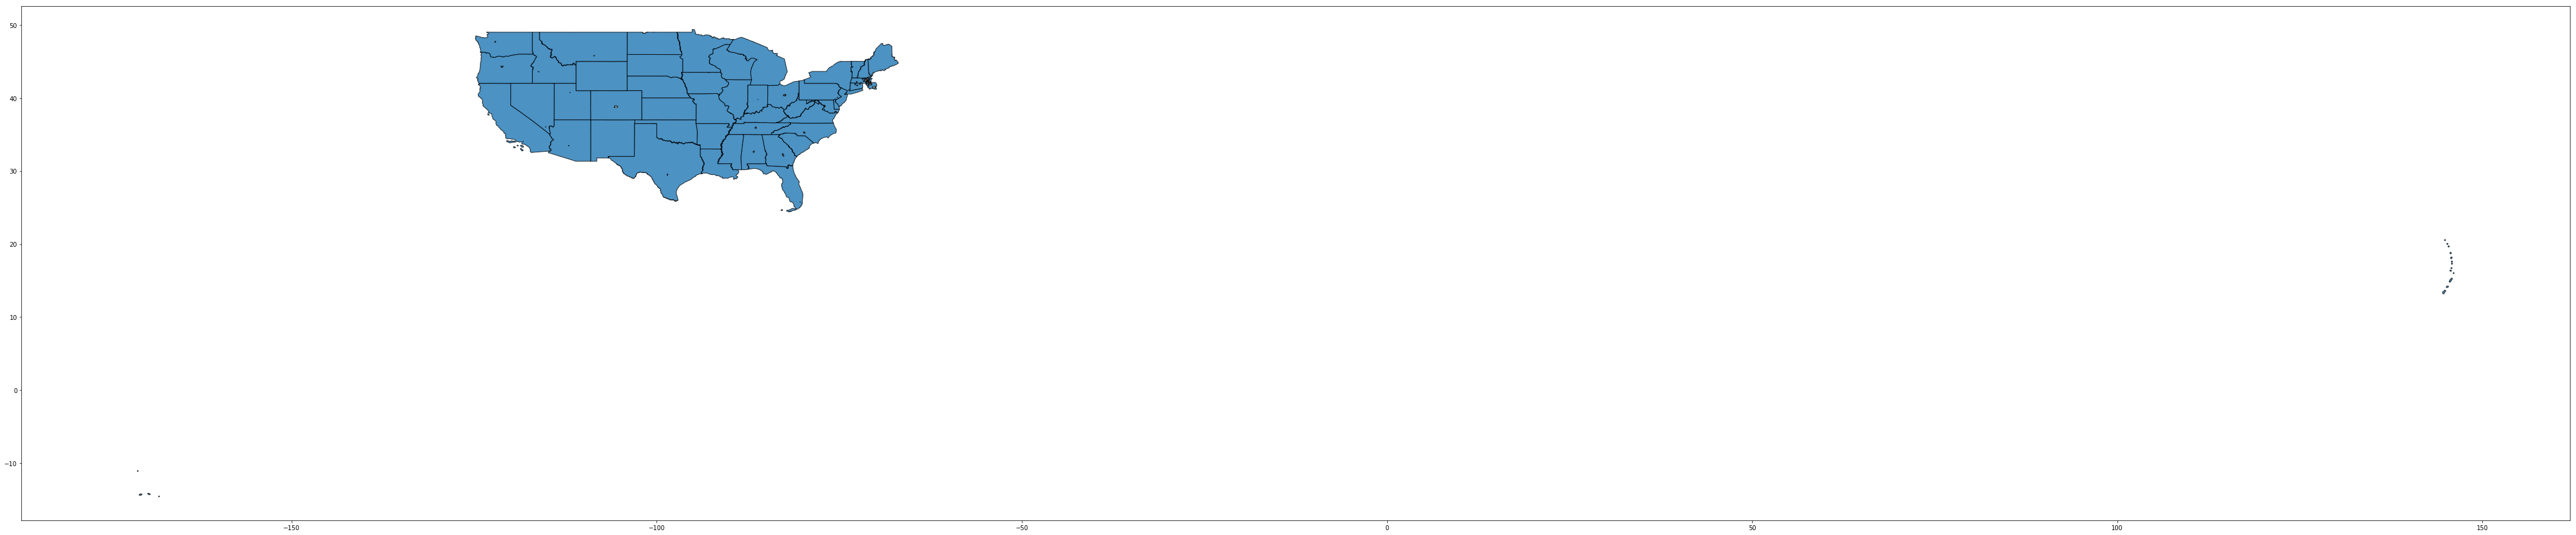

In [10]:
zipMap = newZip_df[newZip_df.Employees > 0]
mymap = gpd.overlay(zipMap, usmap_df, how='symmetric_difference', make_valid=True)
mymap.plot(figsize=(75, 75), alpha=0.8, edgecolor='k')